In [41]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)


In [42]:
merged[['assoc_name_final','quarter','final_weight']].head()

,assoc_name_final,quarter,final_weight
6,"1 CYPRESS RUN, HOMOSASSA, FL 34446",2025-01-01,1.000000
8,"1 OCEAN TRACE RD, ST AUGUSTINE, FL 32080",2021-01-01,2.932088
9,"1 RADIO RD, SAINT AUGUSTINE, FL 32084",2019-04-01,NaN
10,"1 RENAISSANCE WAY, BOYNTON BEACH, FL 33426",2022-01-01,NaN
11,"1 WATER CLUB WAY, NORTH PALM BEACH, FL 33408",2021-07-01,3.328526


In [43]:
# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

In [44]:
event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)

In [45]:
#value_counts = merged['event_time'].value_counts()
#print(value_counts)

In [46]:
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0', 'firststreet_2.0', 'firststreet_3.0',
    'firststreet_4.0', 'firststreet_5.0', 'firststreet_6.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

In [47]:
# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\3671430446.py:11: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr, fema_2.0, fema_3.0, firststreet_2.0, firststreet_3.0, firststreet_4.0, firststreet_5.0, firststreet_6.0

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0074
Estimator:                    PanelOLS   R-squared (Between):              0.0170
No. Observations:                20629   R-squared (Within):               0.1109
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0338
Time:                         14:31:15   Log-likelihood                 1.035e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1104.7
Entities:                         4513   P-value                           0.0000
Avg Obs:                        4.5710   Distribution:                F(27,16062)
Min Obs:                        1.0000                                           
Max Obs:                        28.000   F-statistic (robust):             2.1233
                

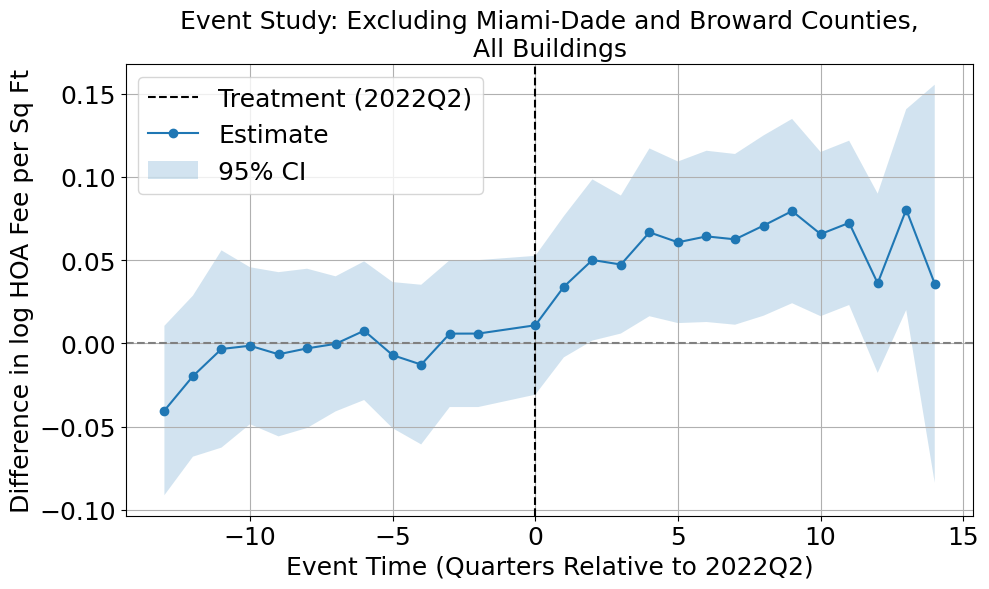

In [48]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\nAll Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe/event_study_HOA_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\635797639.py:82: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0060
Estimator:                    PanelOLS   R-squared (Between):              0.0049
No. Observations:                12783   R-squared (Within):               0.0685
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0167
Time:                         14:20:10   Log-likelihood                    6696.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      895.87
Entities:                         3159   P-value                           0.0000
Avg Obs:                        4.0465   Distribution:                 F(27,9570)
Min Obs:                        1.0000                                           
Max Obs:                        28.000   F-statistic (robust):             0.8923
                

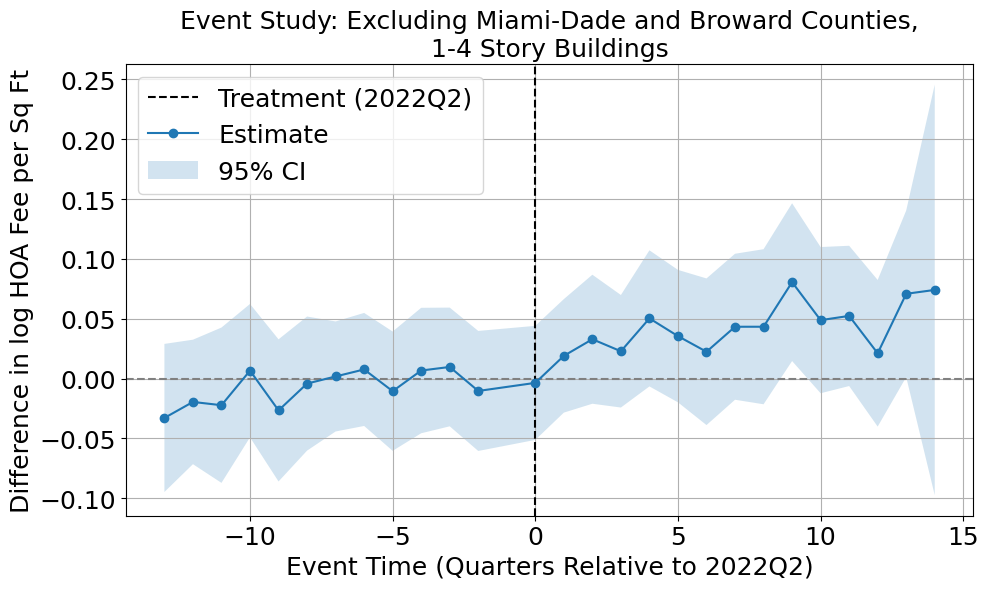

In [23]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\n1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe/event_study_HOA_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\3758843688.py:68: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0076
Estimator:                    PanelOLS   R-squared (Between):              0.0059
No. Observations:                 7033   R-squared (Within):               0.0580
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0206
Time:                         14:20:30   Log-likelihood                    654.23
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      171.30
Entities:                         1808   P-value                           0.0000
Avg Obs:                        3.8899   Distribution:                 F(27,5171)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             1.1303
                

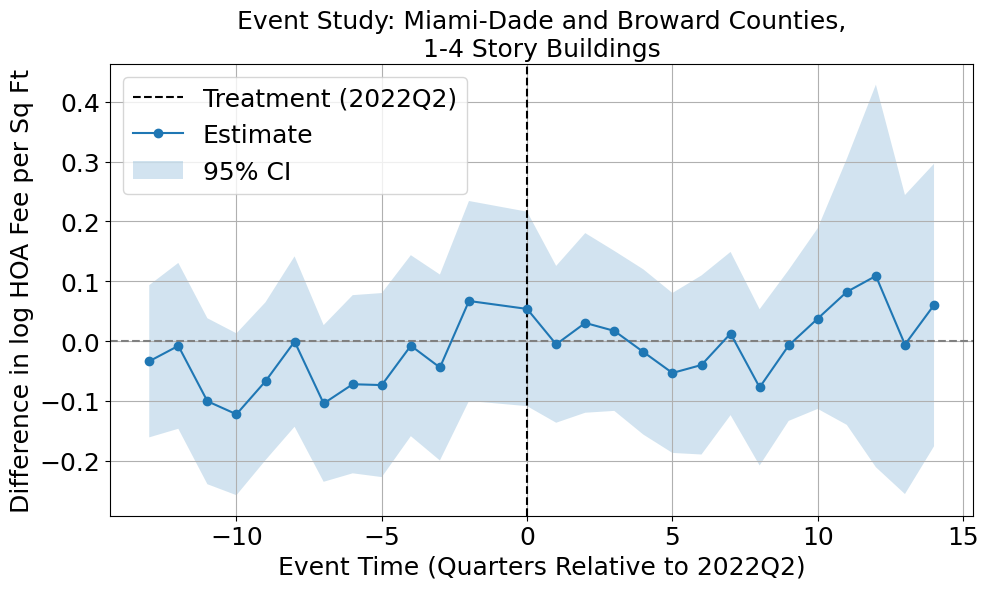

In [24]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))

# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\n1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe/event_study_HOA_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\1709252406.py:68: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0056
Estimator:                    PanelOLS   R-squared (Between):             -0.0089
No. Observations:                16736   R-squared (Within):               0.1340
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0287
Time:                         14:20:52   Log-likelihood                   -52.546
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      185.45
Entities:                         2957   P-value                           0.0000
Avg Obs:                        5.6598   Distribution:                F(27,13725)
Min Obs:                        1.0000                                           
Max Obs:                        28.000   F-statistic (robust):             2.3230
                

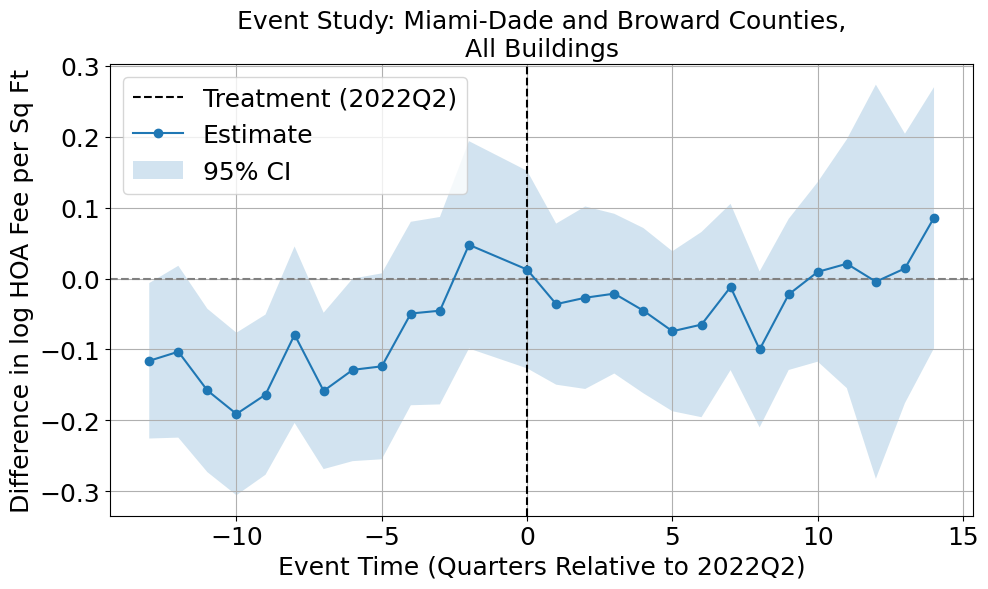

In [25]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))

# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\nAll Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe/event_study_HOA_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1805
Estimator:                    PanelOLS   R-squared (Between):              0.4182
No. Observations:                15906   R-squared (Within):               0.1694
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.2798
Time:                         14:50:29   Log-likelihood                   -5984.5
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      150.89
Entities:                          114   P-value                           0.0000
Avg Obs:                        139.53   Distribution:                F(43,15722)
Min Obs:                        1.0000                                           
Max Obs:                        1209.0   F-statistic (robust):             27.697
                

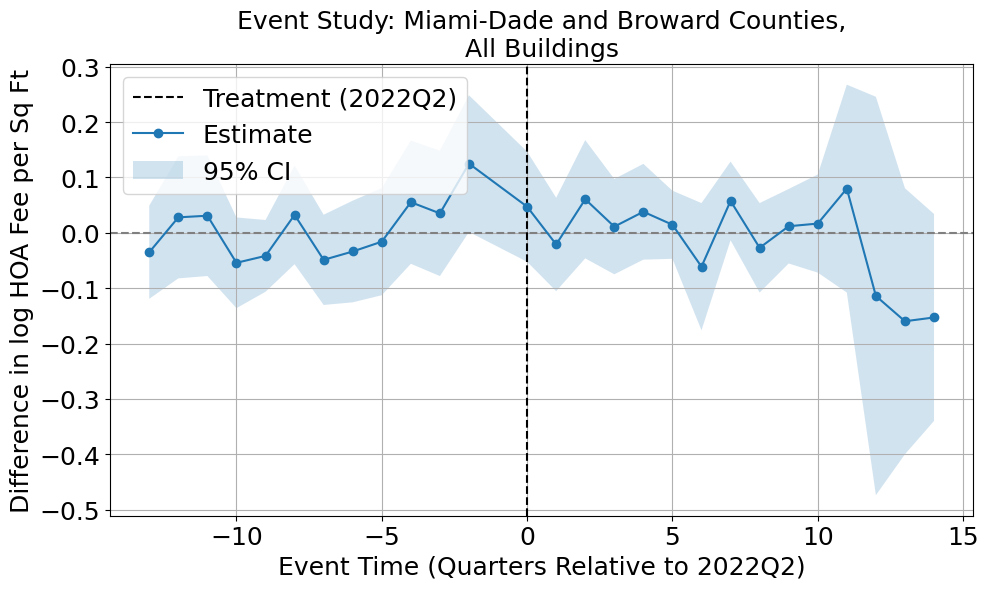

In [62]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))

# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] > 1975) & (merged['yr_blt_attom_assoc'] <= 1980)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] <=1975)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] >1984)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] > 1981) & (merged['yr_blt_attom_assoc'] <= 1986)]
# merged['age_over_40'] = merged['property_age_assoc_qtr'] > 40).astype(int)
# merged = merged[(merged['property_age_assoc_qtr'].notna()) & (merged['property_age_assoc_qtr'] > 40 )]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\nAll Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe/event_study_HOA_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0895
Estimator:                    PanelOLS   R-squared (Between):              0.2866
No. Observations:                 6710   R-squared (Within):               0.0888
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.1696
Time:                         14:50:37   Log-likelihood                   -2071.0
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      73.251
Entities:                          109   P-value                           0.0000
Avg Obs:                        61.560   Distribution:                 F(43,6531)
Min Obs:                        1.0000                                           
Max Obs:                        465.00   F-statistic (robust):             13.420
                

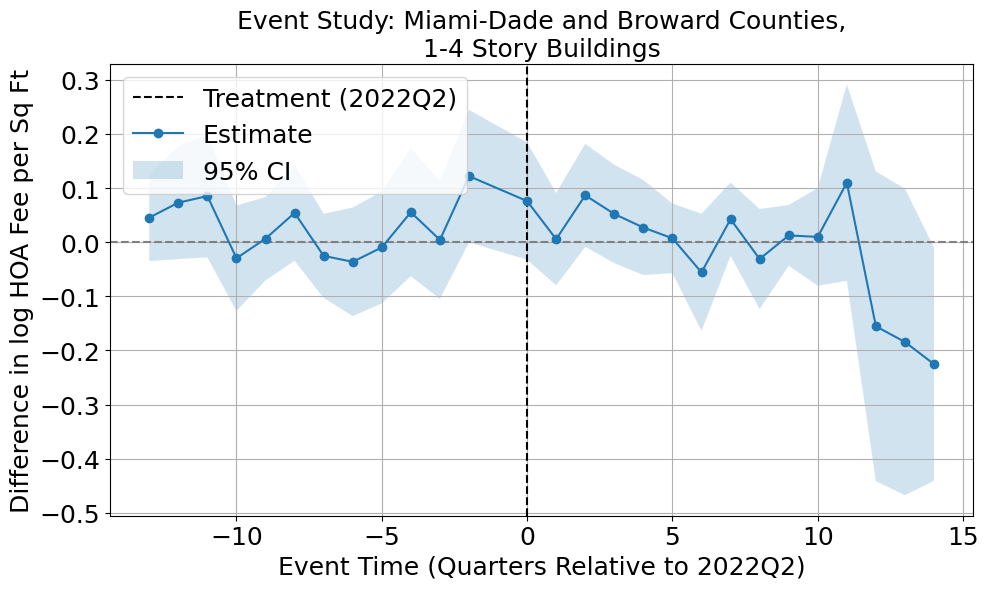

In [63]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))

# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] > 1970) & (merged['yr_blt_attom_assoc'] <= 1975)]
# merged = merged[(merged['yr_blt_attom_assoc'].notna()) & (merged['yr_blt_attom_assoc'] > 1981)]


fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\n1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe/event_study_HOA_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0933
Estimator:                    PanelOLS   R-squared (Between):              0.3675
No. Observations:                 9351   R-squared (Within):               0.1342
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.2586
Time:                         14:50:45   Log-likelihood                   -1145.3
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      152.27
Entities:                          340   P-value                           0.0000
Avg Obs:                        27.503   Distribution:                 F(43,8941)
Min Obs:                        1.0000                                           
Max Obs:                        246.00   F-statistic (robust):             5.9734
                

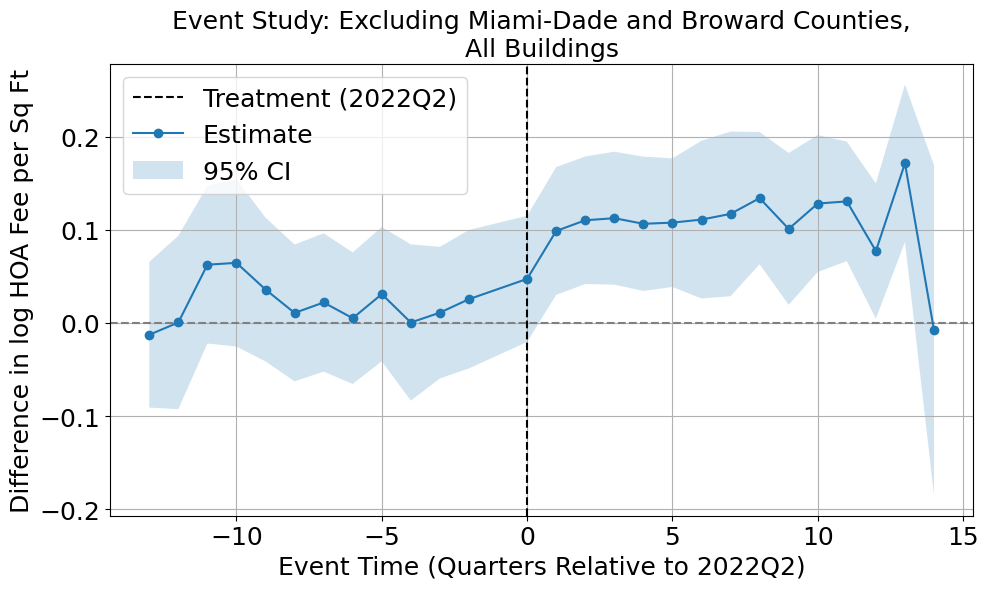

In [64]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin_sirs.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})


# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\nAll Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe/event_study_HOA_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1055
Estimator:                    PanelOLS   R-squared (Between):              0.3606
No. Observations:                10442   R-squared (Within):               0.1437
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.2452
Time:                         14:51:00   Log-likelihood                   -980.51
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      202.96
Entities:                          355   P-value                           0.0000
Avg Obs:                        29.414   Distribution:                F(43,10017)
Min Obs:                        1.0000                                           
Max Obs:                        242.00   F-statistic (robust):             6.5877
                

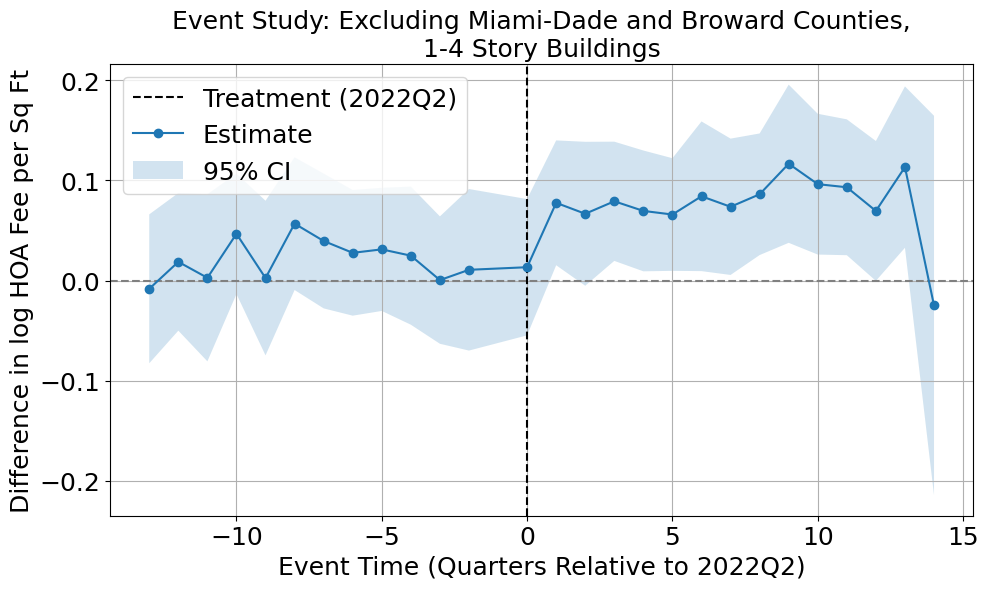

In [65]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\n1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe/event_study_HOA_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\4128998656.py:67: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0072
Estimator:                    PanelOLS   R-squared (Between):              0.0177
No. Observations:                 7033   R-squared (Within):               0.0562
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0286
Time:                         14:39:11   Log-likelihood                    652.63
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      201.05
Entities:                         1808   P-value                           0.0000
Avg Obs:                        3.8899   Distribution:                 F(23,5175)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             1.2478
                

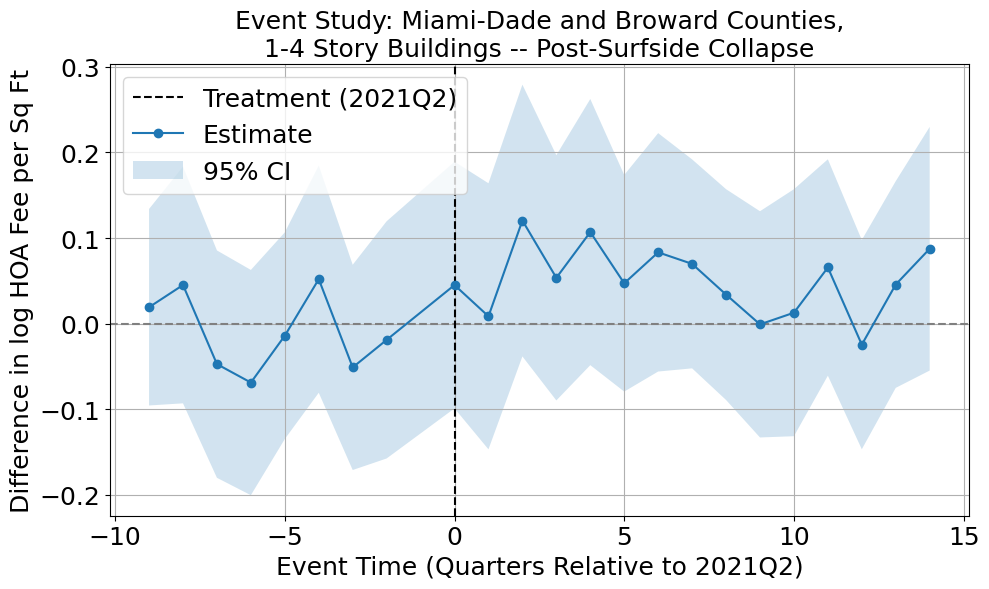

In [55]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\n1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside/assoc_fe/event_study_surfside_HOA_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_47580\1864777646.py:67: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0053
Estimator:                    PanelOLS   R-squared (Between):              0.0237
No. Observations:                16736   R-squared (Within):               0.1243
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0502
Time:                         14:39:18   Log-likelihood                   -54.620
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      217.56
Entities:                         2957   P-value                           0.0000
Avg Obs:                        5.6598   Distribution:                F(23,13729)
Min Obs:                        1.0000                                           
Max Obs:                        28.000   F-statistic (robust):             2.5799
                

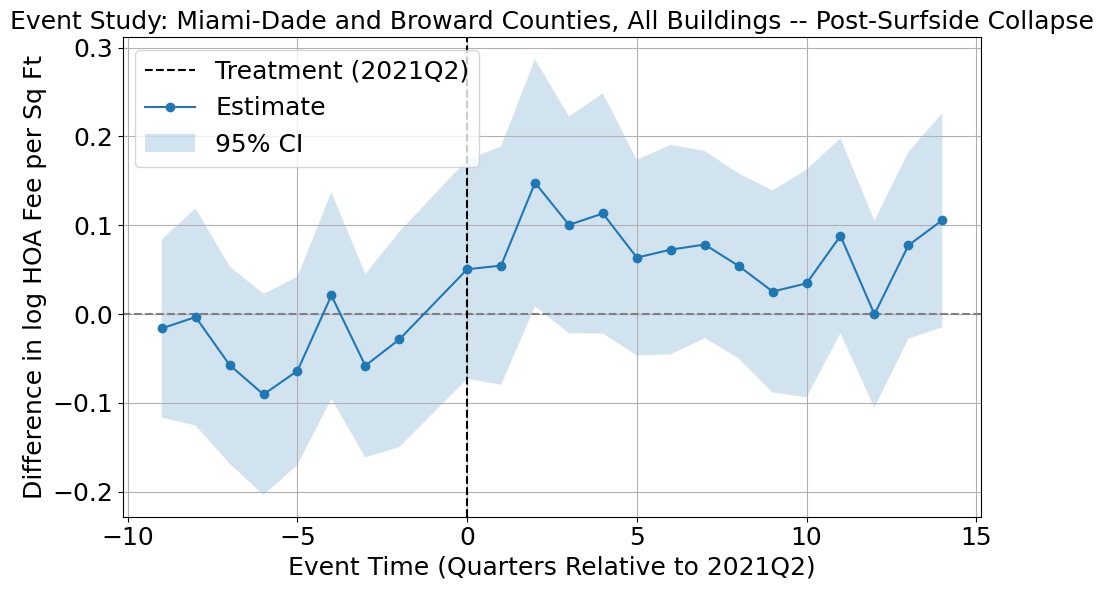

In [56]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside/assoc_fe/event_study_surfside_HOA_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0584
Estimator:                    PanelOLS   R-squared (Between):              0.2125
No. Observations:                 7033   R-squared (Within):               0.0622
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.1223
Time:                         14:51:19   Log-likelihood                   -2336.1
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      82.949
Entities:                          110   P-value                           0.0000
Avg Obs:                        63.936   Distribution:                 F(36,6860)
Min Obs:                        1.0000                                           
Max Obs:                        473.00   F-statistic (robust):             10.825
                

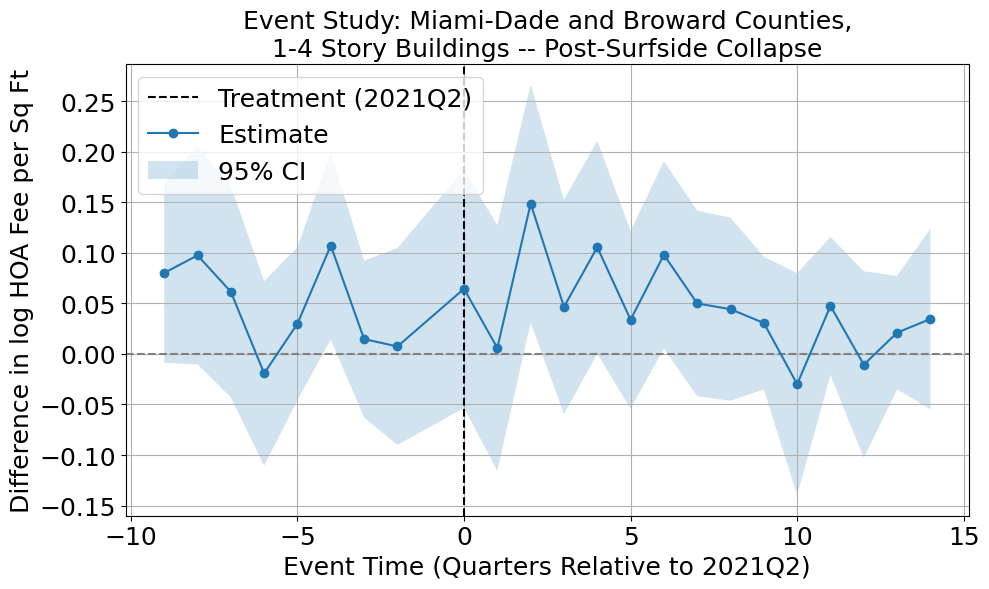

In [66]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\n1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside/zip_fe/event_study_surfside_HOA_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

Rows after filtering: (8156, 81)


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1557
Estimator:                    PanelOLS   R-squared (Between):             -0.2725
No. Observations:                 7848   R-squared (Within):               0.1660
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.1142
Time:                         14:51:34   Log-likelihood                   -3434.2
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      33.679
Entities:                          106   P-value                           0.0000
Avg Obs:                        74.038   Distribution:                 F(42,7673)
Min Obs:                        1.0000                                           
Max Obs:                        678.00   F-statistic (robust):             23.611
                

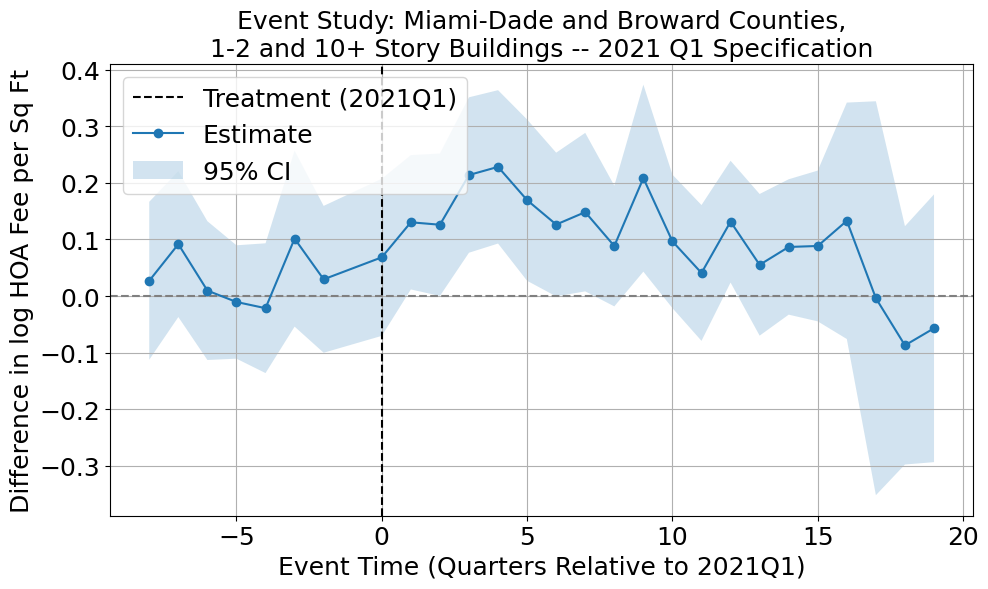

In [67]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
# merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 9)]
merged = merged[
    merged['num_stories_final_assoc'].notna()  # drop missing
    & (
        merged['num_stories_final_assoc'].isin([1, 2])  # 1–2 stories
        | (merged['num_stories_final_assoc'] >= 10)      # 10+ stories
      )
]

# This will keep every group (zip5_attom) for which the condition ever holds
# merged_border = (
#     merged
#     .groupby('zip5_attom')
#     .filter(lambda df: (df['miles_to_coast_assoc'] < 0.5).any())
# )



# merged = merged[(merged['miles_to_coast_assoc'].notna()) & (merged['miles_to_coast_assoc'] < 1)]
# #merged = merged[(merged['property_age_assoc_qtr'].notna()) & (merged['property_age_assoc_qtr'] < 30)]

print("Rows after filtering:", merged.shape)

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# # Compute event time relative to 2021Q2 (i.e., June 2021)
# merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

# event_window = range(-9, 15)
# event_dummies = []

# Event time with 2021Q1 baseline
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 1)

# Event window based on dataset limits
event_window = range(-8, 20)  # Q1 2019 to Q4 2025
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

merged['units_per_building'] = merged['num_units_final_assoc']/merged['num_bldgs_final_assoc']
merged['units_per_floor'] = merged['units_per_building']/merged['num_stories_final_assoc']

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0', 'units_per_building', 'num_bldgs_final_assoc', 'units_per_floor'
]

# Combine X matrix
X = merged[event_dummies + covariates]
#X = sm.add_constant(X)

# import numpy.linalg as la
# print("Rank of X:", la.matrix_rank(X.to_numpy()))
# print("Shape of X:", X.shape)
# print(X.isna().all())
# print(X.shape)
# print(X.dropna().shape)

# for col in X.columns:
#     print(f"{col}: unique values = {X[col].unique()}")

# print("Rows with all NaNs:", (X.isna().all(axis=1)).sum())
# print(X.dtypes)

# non_numeric_cols = X.select_dtypes(include='object').columns
# print("Non-numeric columns in X:", non_numeric_cols.tolist())

# zero_cols = X.columns[(X == 0).all()]
# print("Columns that are entirely 0s:", zero_cols.tolist())

# nonzero_cols = X.columns[(X != 0).any()]
# print("Non-zero columns:", nonzero_cols.tolist())

# print("Untreated units in each event time:")
# print(merged.loc[merged['treated_assoc'] == 0, 'event_time'].value_counts())


# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q1)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties,\n1-2 and 10+ Story Buildings -- 2021 Q1 Specification')
plt.xlabel('Event Time (Quarters Relative to 2021Q1)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside/zip_fe/event_study_surfside_HOA_miami_greater10_q1_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1337
Estimator:                    PanelOLS   R-squared (Between):             -0.4141
No. Observations:                 1349   R-squared (Within):               0.1482
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.3505
Time:                         14:51:49   Log-likelihood                   -238.21
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      4.8932
Entities:                           79   P-value                           0.0000
Avg Obs:                        17.076   Distribution:                 F(38,1205)
Min Obs:                        1.0000                                           
Max Obs:                        93.000   F-statistic (robust):             10.211
                

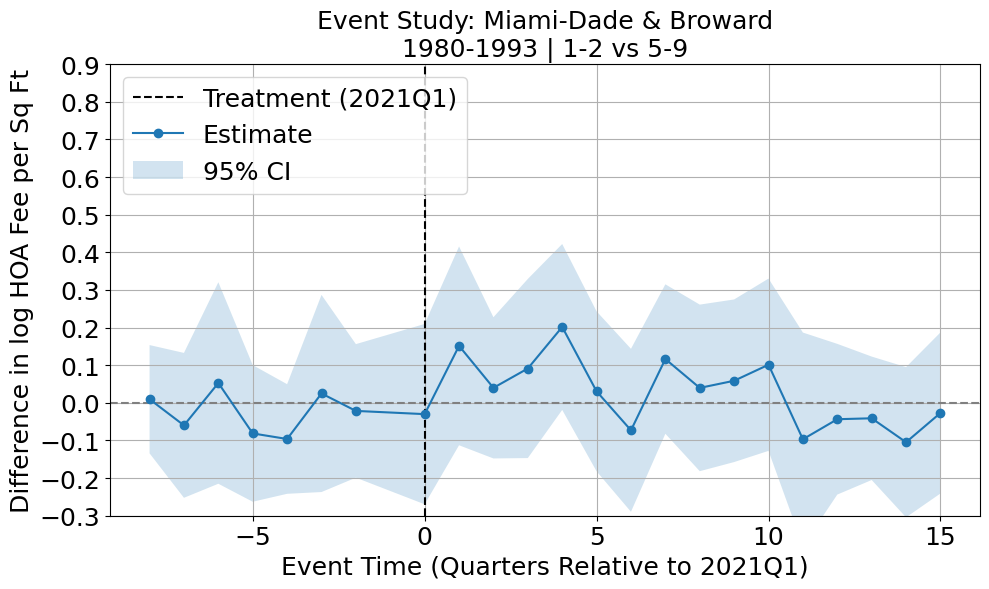

Saved plot: output/plot_2021/zip_fe/event_study_1980-1993_1-2 vs 5-9.png


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0872
Estimator:                    PanelOLS   R-squared (Between):             -0.1249
No. Observations:                 1339   R-squared (Within):               0.1174
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.0828
Time:                         14:51:51   Log-likelihood                   -476.41
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      3.0086
Entities:                           78   P-value                           0.0000
Avg Obs:                        17.167   Distribution:                 F(38,1196)
Min Obs:                        1.0000                                           
Max Obs:                        159.00   F-statistic (robust):             13.149
                

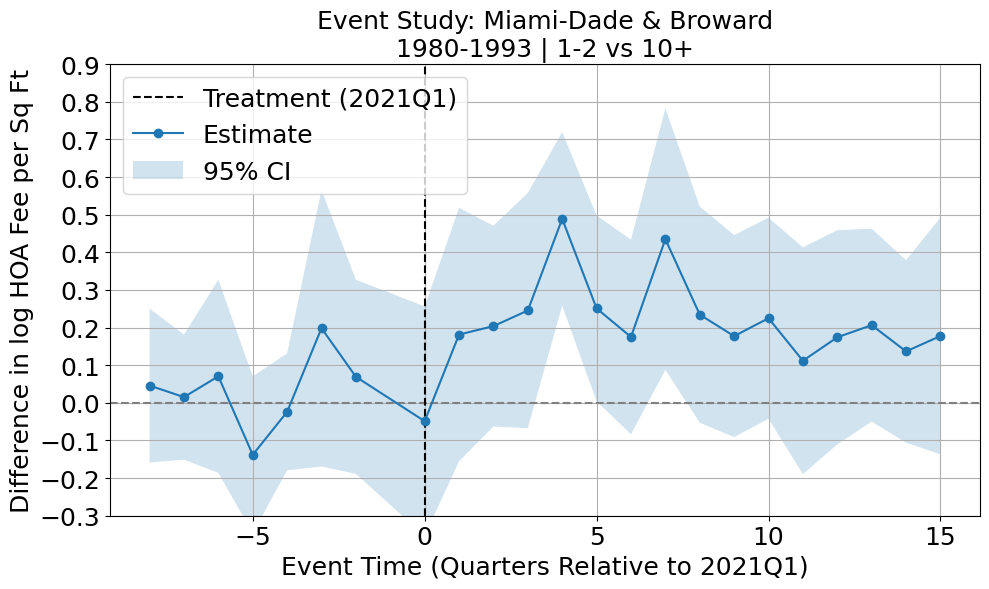

Saved plot: output/plot_2021/zip_fe/event_study_1980-1993_1-2 vs 10+.png
                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0978
Estimator:                    PanelOLS   R-squared (Between):             -0.5845
No. Observations:                 1727   R-squared (Within):               0.1236
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.5089
Time:                         14:51:52   Log-likelihood                   -265.60
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      4.4969
Entities:                           85   P-value                           0.0000
Avg Obs:                        20.318   Distribution:                 F(38,1577)
Min Obs:                        1.0000                                           
Max Obs:                 

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


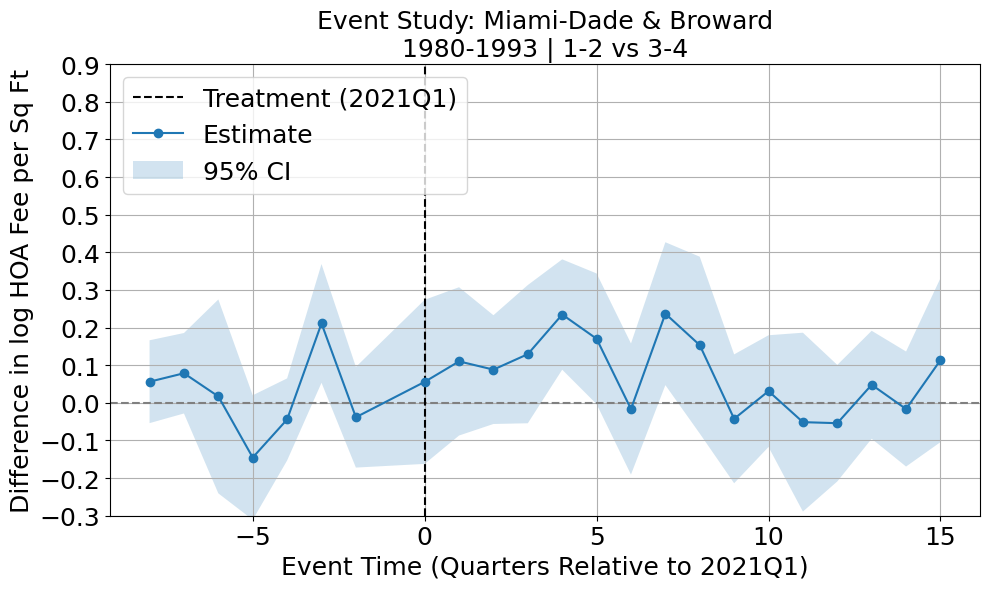

Saved plot: output/plot_2021/zip_fe/event_study_1980-1993_1-2 vs 3-4.png
                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.3445
Estimator:                    PanelOLS   R-squared (Between):              0.0601
No. Observations:                 1106   R-squared (Within):               0.2062
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.0940
Time:                         14:51:53   Log-likelihood                   -310.46
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      13.552
Entities:                           61   P-value                           0.0000
Avg Obs:                        18.131   Distribution:                  F(38,980)
Min Obs:                        1.0000                                           
Max Obs:                 

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


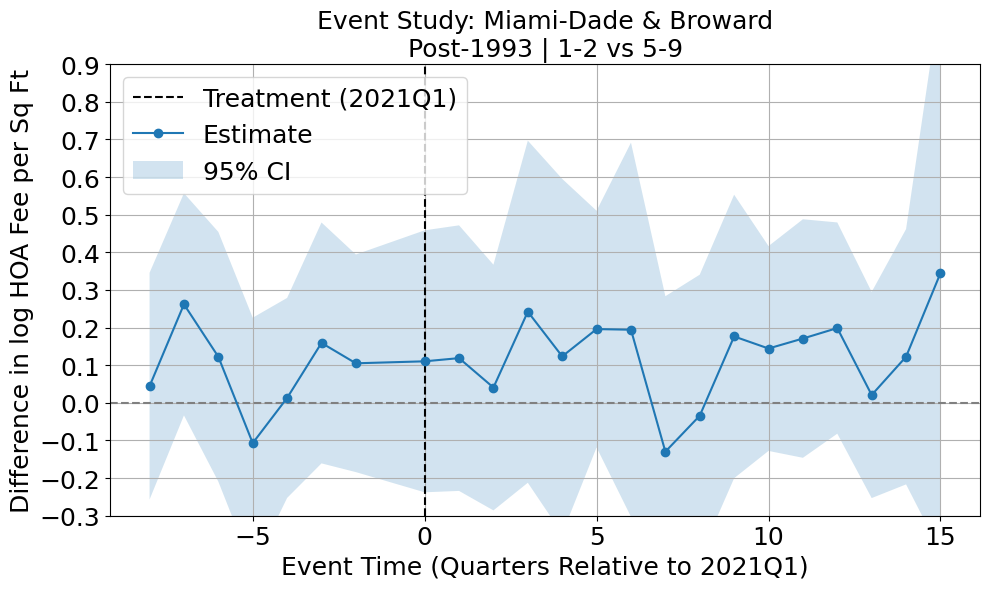

Saved plot: output/plot_2021/zip_fe/event_study_Post-1993_1-2 vs 5-9.png


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1841
Estimator:                    PanelOLS   R-squared (Between):             -1.4654
No. Observations:                 2844   R-squared (Within):               0.0446
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.8148
Time:                         14:51:55   Log-likelihood                   -1131.2
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      16.122
Entities:                           64   P-value                           0.0000
Avg Obs:                        44.438   Distribution:                 F(38,2715)
Min Obs:                        1.0000                                           
Max Obs:                        357.00   F-statistic (robust):             192.94
                

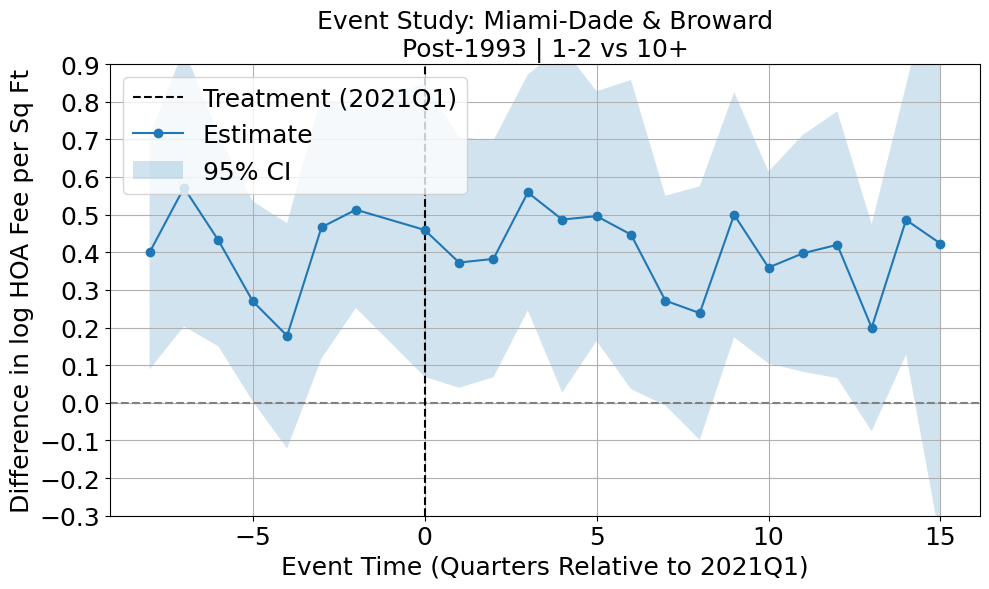

Saved plot: output/plot_2021/zip_fe/event_study_Post-1993_1-2 vs 10+.png
                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1668
Estimator:                    PanelOLS   R-squared (Between):             -0.8339
No. Observations:                  941   R-squared (Within):               0.1145
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.7335
Time:                         14:51:56   Log-likelihood                   -240.94
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      4.2302
Entities:                           74   P-value                           0.0000
Avg Obs:                        12.716   Distribution:                  F(38,803)
Min Obs:                        1.0000                                           
Max Obs:                 

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


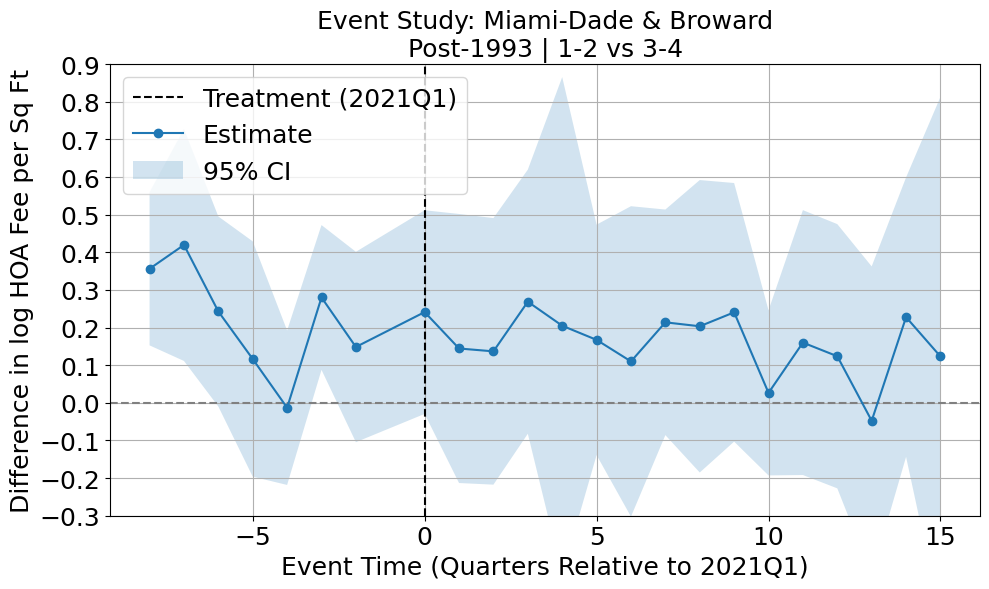

Saved plot: output/plot_2021/zip_fe/event_study_Post-1993_1-2 vs 3-4.png


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0795
Estimator:                    PanelOLS   R-squared (Between):             -1.1180
No. Observations:                 3233   R-squared (Within):               0.1118
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.8746
Time:                         14:51:57   Log-likelihood                   -939.72
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      7.0140
Entities:                           84   P-value                           0.0000
Avg Obs:                        38.488   Distribution:                 F(38,3084)
Min Obs:                        1.0000                                           
Max Obs:                        398.00   F-statistic (robust):             16.971
                

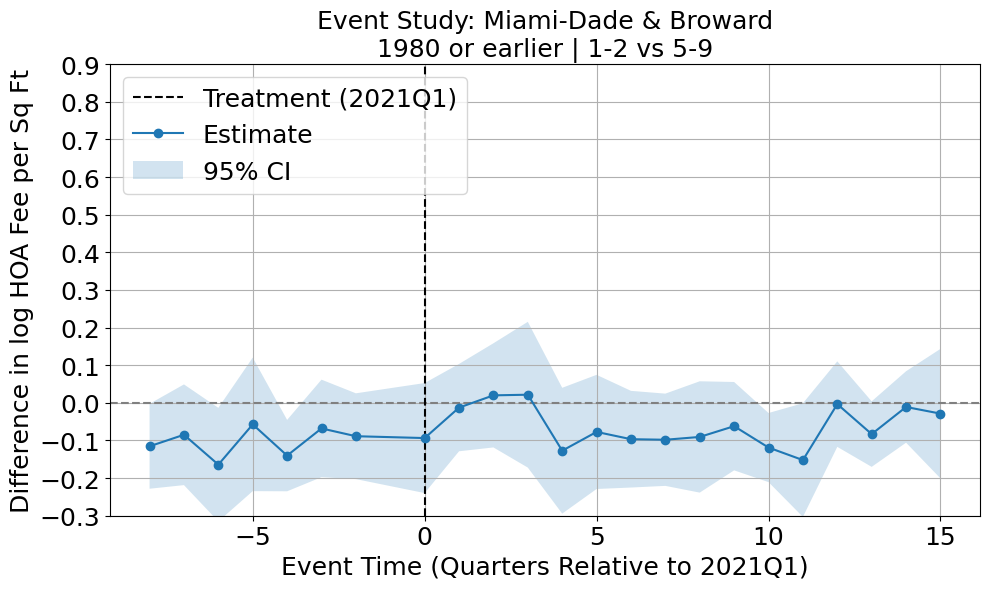

Saved plot: output/plot_2021/zip_fe/event_study_1980 or earlier_1-2 vs 5-9.png


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.1380
Estimator:                    PanelOLS   R-squared (Between):             -3.2945
No. Observations:                 3665   R-squared (Within):               0.2026
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -2.1424
Time:                         14:51:59   Log-likelihood                   -1120.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      14.830
Entities:                           81   P-value                           0.0000
Avg Obs:                        45.247   Distribution:                 F(38,3519)
Min Obs:                        1.0000                                           
Max Obs:                        466.00   F-statistic (robust):             18.326
                

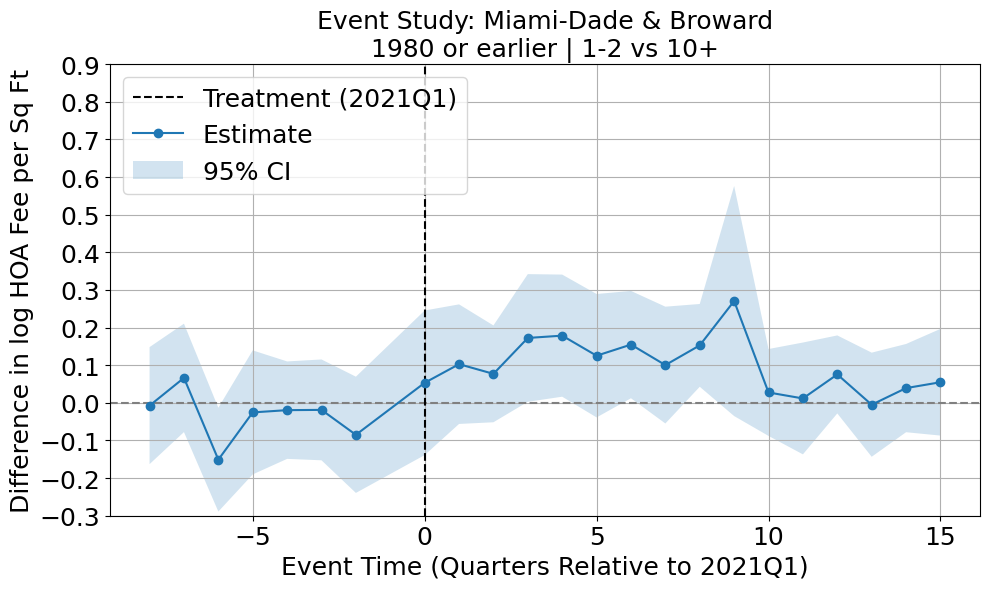

Saved plot: output/plot_2021/zip_fe/event_study_1980 or earlier_1-2 vs 10+.png


C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.0295
Estimator:                    PanelOLS   R-squared (Between):             -1.1007
No. Observations:                 4358   R-squared (Within):               0.0347
Date:                 Tue, Jan 13 2026   R-squared (Overall):             -0.8983
Time:                         14:52:00   Log-likelihood                   -1272.5
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      3.3590
Entities:                           92   P-value                           0.0000
Avg Obs:                        47.370   Distribution:                 F(38,4201)
Min Obs:                        1.0000                                           
Max Obs:                        396.00   F-statistic (robust):             3.9693
                

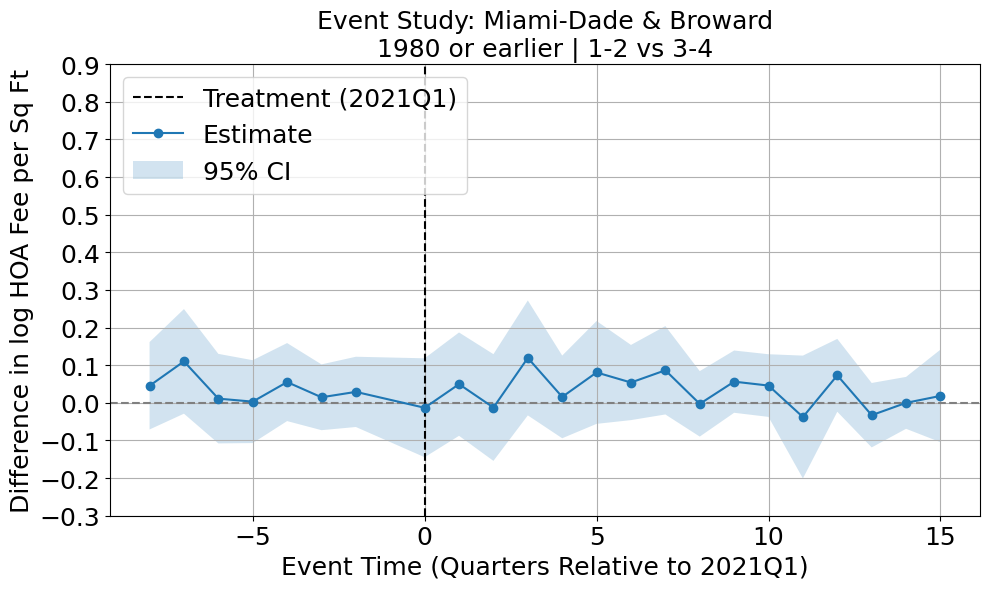

Saved plot: output/plot_2021/zip_fe/event_study_1980 or earlier_1-2 vs 3-4.png


In [68]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0

# def years_since_last_recert(age):
#     if age < 40:
#         # Not yet recertified, return years until first recertification
#         return 40 - age
#     else:
#         # Find last recertification year (40, 50, 60, ...)
#         last_recert = 40 + 10 * ((age - 40) // 10)
#         return age - last_recert

# merged['yrs_since_last_recert'] = merged['property_age_assoc_qtr'].apply(years_since_last_recert)

# Create quartile variable with labels 1–4
# merged['units_quartile'] = pd.qcut(
#     merged['num_units_final_assoc'],
#     q=4,
#     labels=[1, 2, 3, 4]
# )

# merged = merged[merged['units_quartile'] == 4]

# --- Define filters ---
year_filters = {
    "1980-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1979) &
                 (merged['yr_blt_attom_assoc'] <= 1993),
    "Post-1993": (merged['yr_blt_attom_assoc'].notna()) &
                 (merged['yr_blt_attom_assoc'] > 1993),
    "1980 or earlier": (merged['yr_blt_attom_assoc'].notna()) &
                       (merged['yr_blt_attom_assoc'] <= 1979)
}

story_filters = {
    "1-2 vs 5-9": (
        merged['num_stories_final_assoc'].notna() &
        (merged['num_stories_final_assoc'].isin([1, 2]) |
         ((merged['num_stories_final_assoc'] >= 5) &
          (merged['num_stories_final_assoc'] <= 9)))
    ),
    "1-2 vs 10+": (
        merged['num_stories_final_assoc'].notna() &
        (merged['num_stories_final_assoc'].isin([1, 2]) |
         (merged['num_stories_final_assoc'] >= 10))
    ),
    "1-2 vs 3-4": (
        merged['num_stories_final_assoc'].notna() &
        (merged['num_stories_final_assoc'].isin([1, 2, 3, 4]))
    )
}


fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

merged['units_per_building'] = merged['num_units_final_assoc']/merged['num_bldgs_final_assoc']
merged['units_per_floor'] = merged['units_per_building']/merged['num_stories_final_assoc']

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Event time with 2021Q1 baseline
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 1)

# Event window based on dataset limits
event_window = range(-8, 16)  # Q1 2019 to Q4 2024
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0', 'units_per_building', 'num_bldgs_final_assoc', 'units_per_floor'
]

# --- Loop over combinations ---
for y_label, y_cond in year_filters.items():
    for s_label, s_cond in story_filters.items():

        subset = merged[y_cond & s_cond].copy()

        # Set multi-index for panel regression: zip5_attom and quarter
        subset = subset.set_index(['zip5_attom', 'quarter'])

        # Dependent and exogenous variables
        y = subset['hoa_sq_ft_assoc_qtr']
        X = subset[event_dummies + covariates]

        # Fit model
        mod = PanelOLS(
            dependent=y,
            exog=X,
            entity_effects=True,
            time_effects=True,
            weights=subset['final_weight'],
            drop_absorbed=True
        )
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        print(res.summary)

        import matplotlib.pyplot as plt
        plt.rcParams.update({
            'axes.titlesize': 18,
            'axes.labelsize': 18,
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
            'legend.fontsize': 18
        })

        # Extract event-time interaction coefficients
        params = res.params
        conf_int = res.conf_int()
        event_times, coefs, ci_low, ci_high = [], [], [], []

        for col in event_dummies:
            k = int(col.split('_')[1])
            event_times.append(k)
            coefs.append(params[col])
            ci_low.append(conf_int.loc[col][0])
            ci_high.append(conf_int.loc[col][1])

        plot_df = pd.DataFrame({
            'event_time': event_times,
            'coef': coefs,
            'ci_lower': ci_low,
            'ci_upper': ci_high
        }).sort_values('event_time')


        # Plot
        plt.figure(figsize=(10, 6))
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q1)')
        plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
        plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'],
                         alpha=0.2, label='95% CI')

        plt.title(f'Event Study: Miami-Dade & Broward\n{y_label} | {s_label}')
        plt.xlabel('Event Time (Quarters Relative to 2021Q1)', fontsize=18)
        plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.ylim(-0.3, 0.9)
        plt.yticks(np.arange(-0.3, 0.91, 0.1))
        plt.tight_layout()

        # Save with dynamic filename
        filename = f"output/plot_2021/zip_fe/event_study_{y_label}_{s_label}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        print(f"Saved plot: {filename}")





C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2861
Estimator:                    PanelOLS   R-squared (Between):              0.6889
No. Observations:                 9351   R-squared (Within):               0.2847
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.3772
Time:                         14:52:30   Log-likelihood                   -2488.8
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      167.32
Entities:                           36   P-value                           0.0000
Avg Obs:                        259.75   Distribution:                 F(44,8560)
Min Obs:                        1.0000                                           
Max Obs:                        2378.0   F-statistic (robust):         -4.823e+15
                

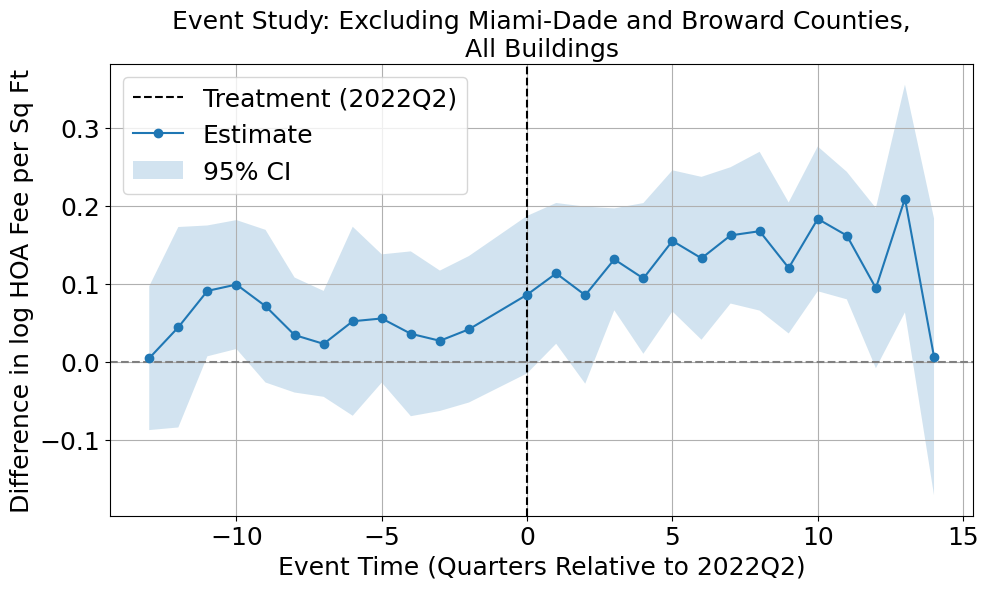

In [70]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin_sirs.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0', 'three_miles_coast_assoc'
]

# keep a proper 2-level index for PanelOLS
merged = merged.set_index(['mm_fips_county_name_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Covariates
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Make county_qtr a categorical effect
merged['county_qtr'] = merged['county_qtr'].astype('category')

# Run weighted regression with zip-quarter FE (and **no** separate zip or quarter FE)
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=False,        # turn off plain county FE
    time_effects=False,          # turn off plain quarter FE
    other_effects=merged[['county_qtr']],  # absorb county-quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})


# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\nAll Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_county_fe/event_study_HOA_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     hoa_sq_ft_assoc_qtr   R-squared:                        0.2652
Estimator:                    PanelOLS   R-squared (Between):              0.7317
No. Observations:                10442   R-squared (Within):               0.2668
Date:                 Tue, Jan 13 2026   R-squared (Overall):              0.3643
Time:                         14:52:47   Log-likelihood                   -2080.7
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      200.33
Entities:                           35   P-value                           0.0000
Avg Obs:                        298.34   Distribution:                 F(45,9646)
Min Obs:                        1.0000                                           
Max Obs:                        2358.0   F-statistic (robust):          6.302e+15
                

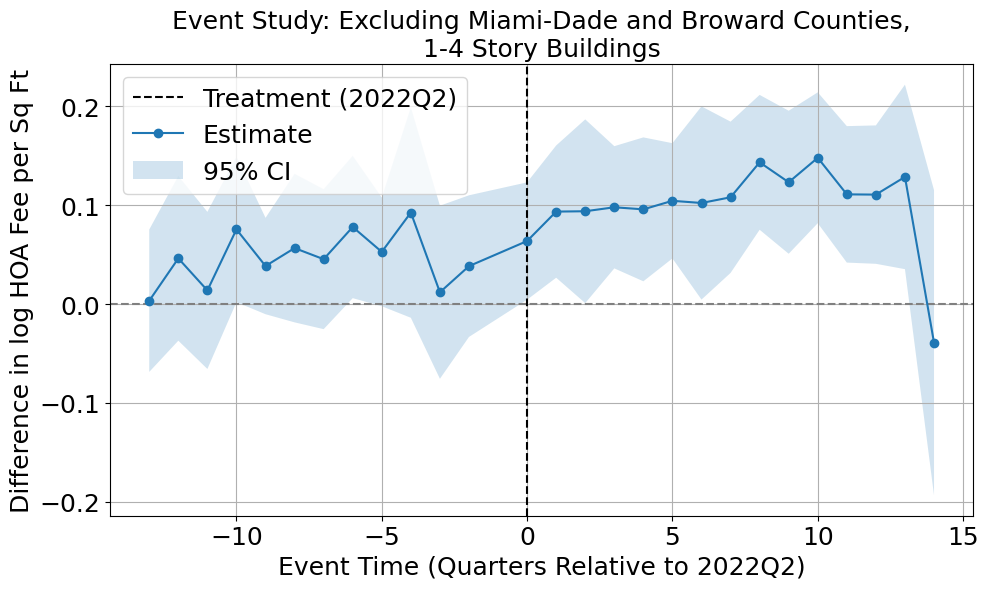

In [71]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

hoa_df = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
merged['hoa_sq_ft_assoc_qtr'] = np.log(merged['hoa_sq_ft_assoc_qtr'].astype(float))
# Fill in weights after 2023Q2 with one
cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc',
    'fema_2.0', 'fema_3.0', 'three_miles_coast_assoc', 'log_percap_income_prop_zip'
]

# keep a proper 2-level index for PanelOLS
merged = merged.set_index(['mm_fips_county_name_attom', 'quarter'])

# Dependent variable
y = merged['hoa_sq_ft_assoc_qtr']

# Covariates
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Make county_qtr a categorical effect
merged['county_qtr'] = merged['county_qtr'].astype('category')

# Run weighted regression with zip-quarter FE (and **no** separate zip or quarter FE)
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=False,        # turn off plain county FE
    time_effects=False,          # turn off plain quarter FE
    other_effects=merged[['county_qtr']],  # absorb county-quarter FE
    weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties,\n1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)', fontsize=18)
plt.ylabel('Difference in log HOA Fee per Sq Ft', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_county_fe/event_study_HOA_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()